In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

クラス分類，教師あり学習の基本

# アイリスデータセット
アヤメのデータ  
特徴量は以下
- がく片の長さ (Sepal length)
- がく片の幅 (Sepal width)
- 花弁の長さ (Petal length)
- 花弁の幅 (Petal width)
- **品種(教師データ)**

サイズが小さい(サンプル数150, 特徴量の数4)ので，可視化や分析が簡単

## 可視化からはじめる
全ての組み合わせについて描画してみる

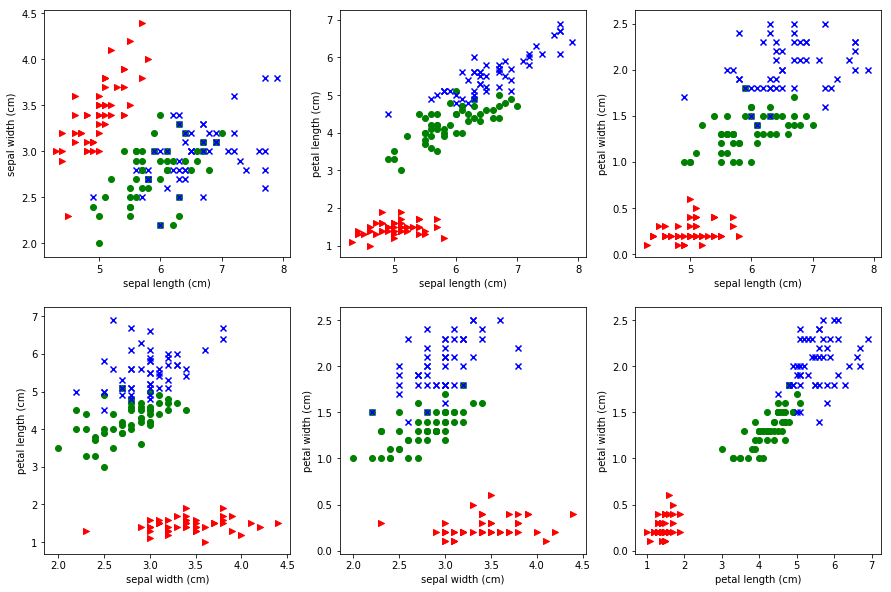

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
features = data['data']
feature_names = data['feature_names']
target = data['target']
target_names = data['target_names']
labels = target_names[target]

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
feature_ids = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for idx, ax in enumerate(axs.flatten()):
    for t, marker, c in zip(range(3), ">ox", "rgb"):
        ax.scatter(features[target == t, feature_ids[idx][0]], features[target == t, feature_ids[idx][1]], marker=marker, c=c)
    ax.set_xlabel(feature_names[feature_ids[idx][0]])
    ax.set_ylabel(feature_names[feature_ids[idx][1]])

## はじめての分類モデル作成
データを見ると，Petal lengthを使えばSetosa(赤)かどうかがわかりそう

In [3]:
plength = features[:, feature_names.index("petal length (cm)")]
is_setosa = (labels == 'setosa') # setosaかどうかのBool配列

max_setosa = plength[is_setosa].max()
min_non_setosa = plength[~is_setosa].min()

print("Maximum of setosa: %.1f" % max_setosa)
print("Minimum of others: %.1f" % min_non_setosa)

Maximum of setosa: 1.9
Minimum of others: 3.0


setosaかそうでないかを分類するモデルが作れる

In [4]:
def apply_model(example):
    if example[feature_names.index("petal length (cm)")] < 2: print("Iris Setosa")
    else: print("Iris Virginica or Iris Versicolor")

VirginicaとVersicolorの分類を行うことは難しい  
もっとも正解率の高い組み合わせを見つけようと思う

In [5]:
is_setosa = (labels == "setosa")
features = features[~is_setosa]
labels = labels[~is_setosa]
virginica = (labels == 'virginica') # virginicaがTrueであるような配列を作成

best_acc = -1.0
best_fi = -1.0
best_t = -1.0

for fi in range(features.shape[1]):
    thresh = features[:, fi].copy()
    thresh.sort()
    
    for t in thresh:
        pred = (features[:, fi] > t)
        acc = (pred == virginica).mean()
        if acc > best_acc:
            best_acc = acc
            best_fi = fi
            best_t = t

print("best acc:", best_acc)
print("best feature:", feature_names[best_fi])
print("best threshold of the feature:", best_t)
            
def apply_model(example):
    if example[best_fi] > best_t: print('virginica')
    else: print('versicolor')

best acc: 0.94
best feature: petal width (cm)
best threshold of the feature: 1.6


判定はできるようにしたが，未知なるデータへの分類能力，**汎化能力**が測定できていない．  
ホールドアウトデータを作成し，同様に測定する

In [6]:
heldout = 50
shuffled = np.random.permutation(range(len(labels)))
features_train = features[sorted(shuffled[heldout:])]
features_test = features[sorted(shuffled[:heldout])]
labels_train = labels[sorted(shuffled[heldout:])]
labels_test = labels[sorted(shuffled[:heldout])]

train_virginica = (labels_train == 'virginica') # virginicaがTrueであるような配列を作成
test_virginica = (labels_test == 'virginica')

best_acc = -1.0
best_fi = -1.0
best_t = -1.0

for fi in range(features_train.shape[1]):
    thresh = features_train[:, fi].copy()
    thresh.sort()
    
    for t in thresh:
        pred = (features_train[:, fi] > t)
        acc = (pred == train_virginica).mean()
        if acc > best_acc:
            best_acc = acc
            best_fi = fi
            best_t = t

print("train acc:", best_acc)
print("train feature:", feature_names[best_fi])
print("train threshold of the feature:", best_t)
            
def apply_model(example):
    if example[best_fi] > best_t: print('virginica')
    else: print('versicolor')
        
test_pred = (features_test[:, best_fi] > best_t)
test_acc = (test_pred == test_virginica).mean()
print("test acc:", test_acc)

train acc: 1.0
train feature: petal width (cm)
train threshold of the feature: 1.5
test acc: 0.84


ホールドアウトによるテストはデータが少なくなってしまう．  
そこで，**交差検定(cross validation)** という方法がある．  
交差検定法の一つに，**leave-one-out法** がある．  
これは，訓練データから1つのデータを取り除き，それ以外のデータで訓練をした後，取り除いたデータを正しく分類できるか確かめる方法である．  

In [9]:
from ch02.threshold import learn_model, apply_model

error = 0.0
for ei in range(len(features)):
    # ei番目を除いたすべてのデータを用いて訓練する
    training = np.ones(len(features), bool)
    training[ei] = False
    testing = ~training
    model = learn_model(features[training], virginica[training])
    predictions = apply_model(features[testing], model)
    error += np.sum(predictions != virginica[testing])
    
print(f"leave-one-out error:{error} / {len(features)}")

leave-one-out error:13.0 / 100
